# **Importações**


In [11]:
import pandas as pd
import numpy as np
import itertools
import math
import csv

import matplotlib.pyplot as plt

from copy import deepcopy

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# **GridSearch Manual**

In [ ]:
# === 1. Carregar dados ===
df = pd.read_csv('/content/drive/MyDrive/Projeto Ciência de Dados/dados-manaus-preprocessado.csv')
df = df[df['ano'] >= 2000].drop(columns=['municipio', 'uf'])
X_df = df.drop(columns='vazao')
y_df = df['vazao']
target_column = 'vazao'
target_index = df.columns.get_loc(target_column)

# === 2. Normalizar ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# === 3. Função para criar janelas ===
def create_multistep_sequences(data, target_index, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon, target_index])
    return np.array(X), np.array(y)

# === 4. Função para treinar modelo ===
def run_experiment(window_size, epochs, batch_size, val_split, verbose):
    forecast_horizon = window_size // 2
    X, y = create_multistep_sequences(scaled_data, target_index, window_size, forecast_horizon)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential()
    model.add(Input(shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(forecast_horizon))
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=val_split,
                        callbacks=[es],
                        verbose=verbose)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Reverter normalização
    scale = scaler.scale_[target_index]
    min_ = scaler.min_[target_index]
    def denorm(y): return y * (1 / scale) + min_

    y_train_real = denorm(y_train)
    y_test_real = denorm(y_test)
    y_train_pred_real = denorm(y_train_pred)
    y_test_pred_real = denorm(y_test_pred)

    # Métricas (média dos horizontes)
    rmse_train = np.mean([np.sqrt(mean_squared_error(y_train_real[:, i], y_train_pred_real[:, i])) for i in range(forecast_horizon)])
    rmse_test = np.mean([np.sqrt(mean_squared_error(y_test_real[:, i], y_test_pred_real[:, i])) for i in range(forecast_horizon)])
    r2_train = np.mean([r2_score(y_train_real[:, i], y_train_pred_real[:, i]) for i in range(forecast_horizon)])
    r2_test = np.mean([r2_score(y_test_real[:, i], y_test_pred_real[:, i]) for i in range(forecast_horizon)])

    return {
        'window_size': window_size,
        'forecast_horizon': forecast_horizon,
        'epochs': epochs,
        'batch_size': batch_size,
        'val_split': val_split,
        'verbose': verbose,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r2_train': r2_train,
        'r2_test': r2_test
    }

# === 5. Hiperparâmetros a testar ===
param_grid = {
    'window_size': [14, 30, 50],
    'epochs': [50, 100],
    'batch_size': [16, 32],
    'val_split': [0.1, 0.2],
    'verbose': [0]  # Mantenha 0 para não lotar o output
}

combinations = list(itertools.product(*param_grid.values()))

# === 6. Rodar experimentos ===
results = []
for params in combinations:
    config = dict(zip(param_grid.keys(), params))
    print(f"Executando: {config}")
    result = run_experiment(**config)
    print(result)
    results.append(result)

# === 7. Salvar resultados ===
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='r2_test', ascending=False)
results_df.to_csv('/content/resultados_LSTM_param_grid.csv', index=False)

# Mostrar top 5 resultados
print("\nTop 5 combinações:")
print(results_df.head())


Executando: {'window_size': 14, 'epochs': 50, 'batch_size': 16, 'val_split': 0.1, 'verbose': 0}
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
{'window_size': 14, 'forecast_horizon': 7, 'epochs': 50, 'batch_size': 16, 'val_split': 0.1, 'verbose': 0, 'rmse_train': np.float64(2912.26359843662), 'rmse_test': np.float64(6395.745292979421), 'r2_train': np.float64(0.9944749540117209), 'r2_test': np.float64(0.9767320042946827)}
Executando: {'window_size': 14, 'epochs': 50, 'batch_size': 16, 'val_split': 0.2, 'verbose': 0}
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
{'window_size': 14, 'forecast_horizon': 7, 'epochs': 50, 'batch_size': 16, 'val_split': 0.2, 'verbose': 0, 'rmse_train': np.float64(2925.3965457753657), 'rmse_test': np.float64(6247.339908526874), 'r2_train': np.float64(0.9945253120720032), 'r2_test': np.float64(0.9776824853206121)}
Executando: {'window_size': 14, 'epochs': 50, 'batch_size': 32, 'val_split': 0.1, 

# **Avaliando Melhor  Modelo**

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE Treino: 1,033.636
RMSE Teste: 7,016.036
R² Treino: 0.999
R² Teste: 0.973


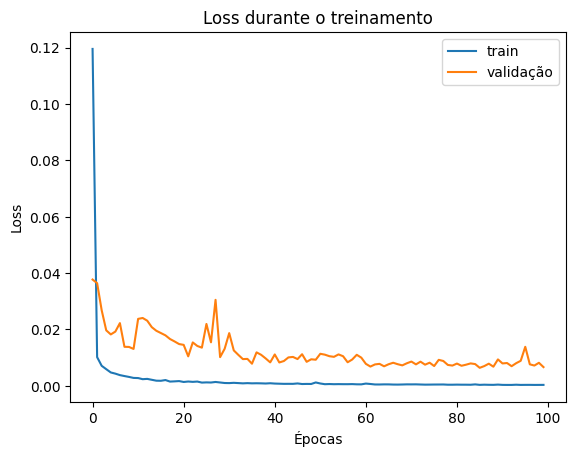

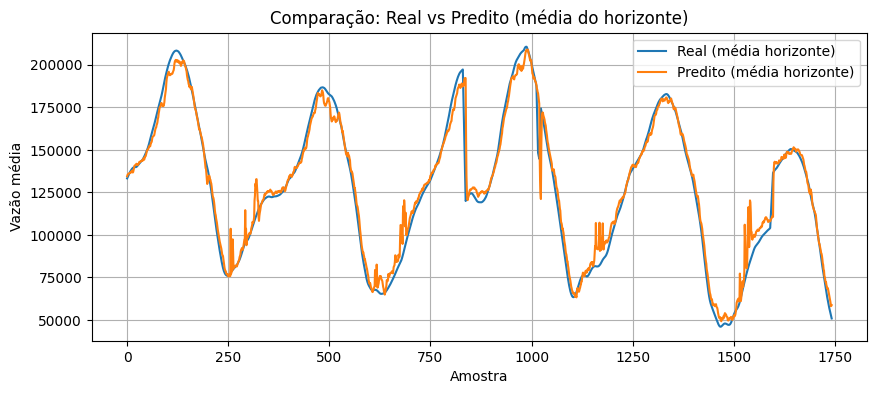

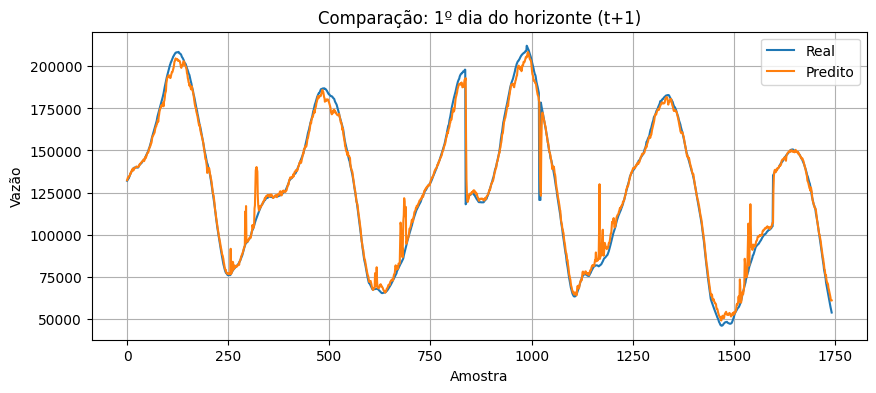

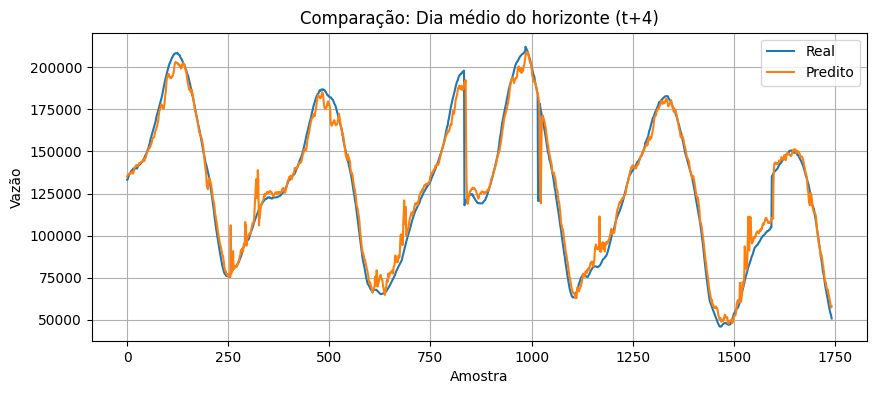

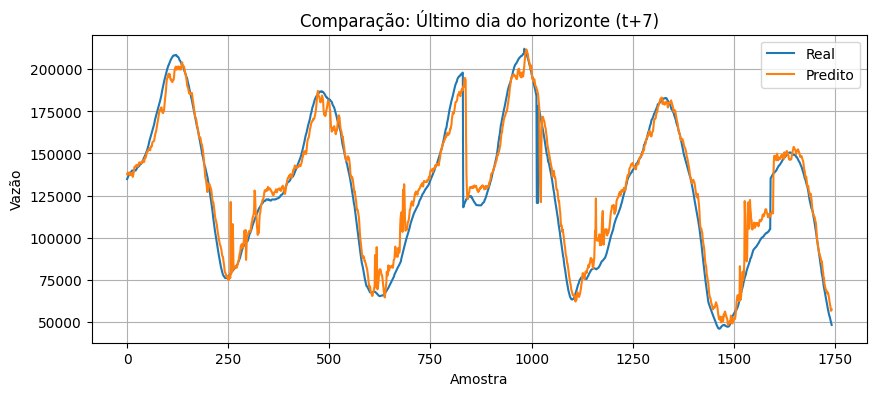

In [ ]:
# 1. Carregamento
df = pd.read_csv('/content/drive/MyDrive/Projeto Ciência de Dados/dados-manaus-preprocessado.csv')
df = df[df['ano'] >= 2000]
df = df.drop(columns=['municipio', 'uf'])

# 2. Separar variáveis
X_df = df.drop(columns='vazao')
y_df = df['vazao']

# 3. Escalar com StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
target_index = df.columns.get_loc('vazao')

# 4. Criar janelas
def create_sequences(data, target_index, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - horizon):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon, target_index])
    return np.array(X), np.array(y)

lookback = 14
horizon = 7
X, y = create_sequences(scaled_data, target_index, lookback, horizon)

# 5. Dividir treino/teste
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Modelo
model = Sequential()
model.add(Input(shape=(lookback, X.shape[2])))  # Define a entrada
model.add(LSTM(50))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

# 7. Treinamento
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

# 8. Previsão
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 9. Reverter normalização e tirar a média no horizonte
vazao_mean = scaler.mean_[target_index]
vazao_std = scaler.scale_[target_index]

y_train_real = y_train * vazao_std + vazao_mean
y_test_real = y_test * vazao_std + vazao_mean
y_train_pred_real = y_train_pred * vazao_std + vazao_mean
y_test_pred_real = y_test_pred * vazao_std + vazao_mean

# Calcular média ao longo do horizonte (por linha)
y_train_real_mean = y_train_real.mean(axis=1)
y_test_real_mean = y_test_real.mean(axis=1)
y_train_pred_mean = y_train_pred_real.mean(axis=1)
y_test_pred_mean = y_test_pred_real.mean(axis=1)

# 10. Métricas
train_rmse = math.sqrt(mean_squared_error(y_train_real_mean, y_train_pred_mean))
test_rmse = math.sqrt(mean_squared_error(y_test_real_mean, y_test_pred_mean))
train_r2 = r2_score(y_train_real_mean, y_train_pred_mean)
test_r2 = r2_score(y_test_real_mean, y_test_pred_mean)

print(f"RMSE Treino: {train_rmse:,.3f}")
print(f"RMSE Teste: {test_rmse:,.3f}")
print(f"R² Treino: {train_r2:.3f}")
print(f"R² Teste: {test_r2:.3f}")

# 11. Plot da perda
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Loss durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 12. Comparação real x predito (médias)
plt.figure(figsize=(10, 4))
plt.plot(y_test_real_mean, label='Real (média horizonte)')
plt.plot(y_test_pred_mean, label='Predito (média horizonte)')
plt.title('Comparação: Real vs Predito (média do horizonte)')
plt.xlabel('Amostra')
plt.ylabel('Vazão média')
plt.legend()
plt.grid(True)
plt.show()

# === 13. Gráficos para t+1, média e t+7 ===
indices = [0, horizon // 2, horizon - 1]
titulos = ['1º dia do horizonte (t+1)', 'Dia médio do horizonte (t+4)', 'Último dia do horizonte (t+7)']

for idx, titulo in zip(indices, titulos):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_real[:, idx], label='Real')
    plt.plot(y_test_pred_real[:, idx], label='Predito')
    plt.title(f'Comparação: {titulo}')
    plt.xlabel('Amostra')
    plt.ylabel('Vazão')
    plt.legend()
    plt.grid(True)
    plt.show()

# **Avaliando com Cross-Validation (TimeSeriesSplit)**

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[SEM CV] RMSE Treino: 1,114.047
[SEM CV] RMSE Teste: 6,254.485
[SEM CV] R² Treino: 0.999
[SEM CV] R² Teste: 0.978
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[Fold 1] RMSE Treino: 417.300 | RMSE Validação: 14160.483
           R² Treino: 1.000 | R² Validação: 0.829
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[Fold 2] RMSE Treino: 585.437 | RMSE Validação: 6070.773
           R² Treino: 1.000 | R² Validação: 0.981
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[Fold 3] RMSE Treino: 624.072 | RMSE Validação: 3884.069
           R² Treino: 1.000 | R² Validação: 0.992
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[Fold 4] RMSE Treino: 660.475 | RMSE Validação: 8755.606
           R² Treino: 1.000 | R² Validação: 0.952
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
46/46 ━━━━━━━━━━━━━━

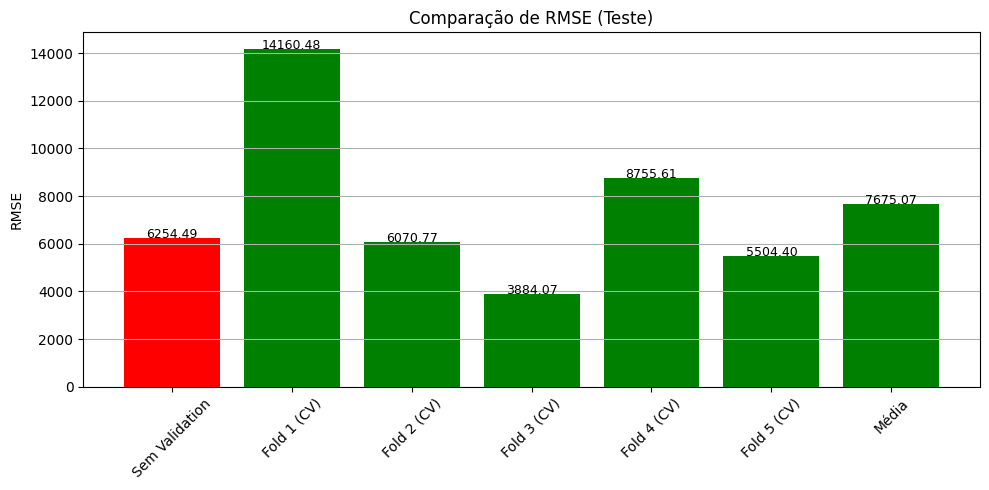

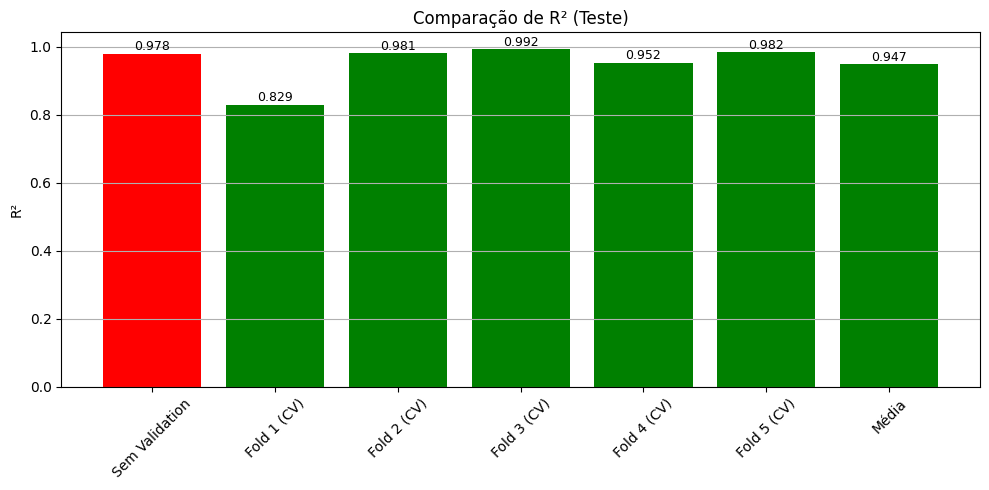

In [ ]:
# === Parte 1: Modelo normal (sem cross-validation) ===

model = Sequential()
model.add(Input(shape=(lookback, X.shape[2])))
model.add(LSTM(50))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_real = y_train_pred * vazao_std + vazao_mean
y_test_pred_real = y_test_pred * vazao_std + vazao_mean

y_train_real_mean = y_train_real.mean(axis=1)
y_test_real_mean = y_test_real.mean(axis=1)
y_train_pred_mean = y_train_pred_real.mean(axis=1)
y_test_pred_mean = y_test_pred_real.mean(axis=1)

# Métricas sem cross-validation
baseline_train_rmse = math.sqrt(mean_squared_error(y_train_real_mean, y_train_pred_mean))
baseline_test_rmse = math.sqrt(mean_squared_error(y_test_real_mean, y_test_pred_mean))
baseline_train_r2 = r2_score(y_train_real_mean, y_train_pred_mean)
baseline_test_r2 = r2_score(y_test_real_mean, y_test_pred_mean)

print(f"[SEM CV] RMSE Treino: {baseline_train_rmse:,.3f}")
print(f"[SEM CV] RMSE Teste: {baseline_test_rmse:,.3f}")
print(f"[SEM CV] R² Treino: {baseline_train_r2:.3f}")
print(f"[SEM CV] R² Teste: {baseline_test_r2:.3f}")

# Inicializar lista de resultados
resultados = [
    {
        'modelo': 'Sem Validation',
        'splits': 0,
        'RMSE Treino': baseline_train_rmse,
        'RMSE Teste': baseline_test_rmse,
        'R² Treino': baseline_train_r2,
        'R² Teste': baseline_test_r2
    }
]

# === Parte 2: Cross-validation com TimeSeriesSplit ===

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
cv_train_rmses, cv_test_rmses = [], []
cv_train_r2s, cv_test_r2s = [], []

fold = 1

for train_idx, val_idx in tscv.split(X):
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    model_cv = Sequential()
    model_cv.add(Input(shape=(lookback, X.shape[2])))
    model_cv.add(LSTM(50))
    model_cv.add(Dense(horizon))
    model_cv.compile(optimizer='adam', loss='mse')

    model_cv.fit(X_train_cv, y_train_cv, epochs=100, batch_size=16, verbose=0)

    y_train_pred_cv = model_cv.predict(X_train_cv)
    y_val_pred_cv = model_cv.predict(X_val_cv)

    y_train_real_cv = y_train_cv * vazao_std + vazao_mean
    y_val_real_cv = y_val_cv * vazao_std + vazao_mean
    y_train_pred_real_cv = y_train_pred_cv * vazao_std + vazao_mean
    y_val_pred_real_cv = y_val_pred_cv * vazao_std + vazao_mean

    y_train_real_mean_cv = y_train_real_cv.mean(axis=1)
    y_val_real_mean_cv = y_val_real_cv.mean(axis=1)
    y_train_pred_mean_cv = y_train_pred_real_cv.mean(axis=1)
    y_val_pred_mean_cv = y_val_pred_real_cv.mean(axis=1)

    rmse_train_cv = math.sqrt(mean_squared_error(y_train_real_mean_cv, y_train_pred_mean_cv))
    rmse_val_cv = math.sqrt(mean_squared_error(y_val_real_mean_cv, y_val_pred_mean_cv))
    r2_train_cv = r2_score(y_train_real_mean_cv, y_train_pred_mean_cv)
    r2_val_cv = r2_score(y_val_real_mean_cv, y_val_pred_mean_cv)

    print(f"[Fold {fold}] RMSE Treino: {rmse_train_cv:.3f} | RMSE Validação: {rmse_val_cv:.3f}")
    print(f"           R² Treino: {r2_train_cv:.3f} | R² Validação: {r2_val_cv:.3f}")

    cv_train_rmses.append(rmse_train_cv)
    cv_test_rmses.append(rmse_val_cv)
    cv_train_r2s.append(r2_train_cv)
    cv_test_r2s.append(r2_val_cv)

    fold += 1

for i in range(n_splits):
    resultados.append({
        'modelo': f'Fold {i + 1} (CV)',
        'splits': n_splits,
        'RMSE Treino': cv_train_rmses[i],
        'RMSE Teste': cv_test_rmses[i],
        'R² Treino': cv_train_r2s[i],
        'R² Teste': cv_test_r2s[i]
    })

resultados.append({
    'modelo': 'Média',
    'splits': n_splits,
    'RMSE Treino': np.mean(cv_train_rmses),
    'RMSE Teste': np.mean(cv_test_rmses),
    'R² Treino': np.mean(cv_train_r2s),
    'R² Teste': np.mean(cv_test_r2s)
})

# === Parte 3: Exportar resultados para CSV ===

df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("resultados_LSTM_TimeSeriesSplit.csv", index=False)
print("\nArquivo 'resultados_LSTM_TimeSeriesSplit.csv' salvo com sucesso.")

# === Parte 4: Gráficos comparativos ===

labels = [r['modelo'] for r in resultados]
cores = ['red'] + ['green'] * (len(labels) - 1)  # Vermelho para o baseline, verde para os folds

# Gráfico RMSE Teste
plt.figure(figsize=(10, 5))
plt.bar(labels, [r['RMSE Teste'] for r in resultados], color=cores)
plt.title('Comparação de RMSE (Teste)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
for i, v in enumerate([r['RMSE Teste'] for r in resultados]):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=9)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Gráfico R² Teste
plt.figure(figsize=(10, 5))
plt.bar(labels, [r['R² Teste'] for r in resultados], color=cores)
plt.title('Comparação de R² (Teste)')
plt.ylabel('R²')
plt.xticks(rotation=45)
for i, v in enumerate([r['R² Teste'] for r in resultados]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# **Análise de Variáveis**

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE base (teste): 7175.94
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Variável 0: aumento médio de RMSE = 438.46
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Variável 1: aumento médio de RMSE = 1085.78
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Variável 2: aumento médio de RMSE = 361.93
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Variável 3: aumento médio de RMSE = 230.27
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Variável 4: aumento médio de RMSE = 50070.00
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━

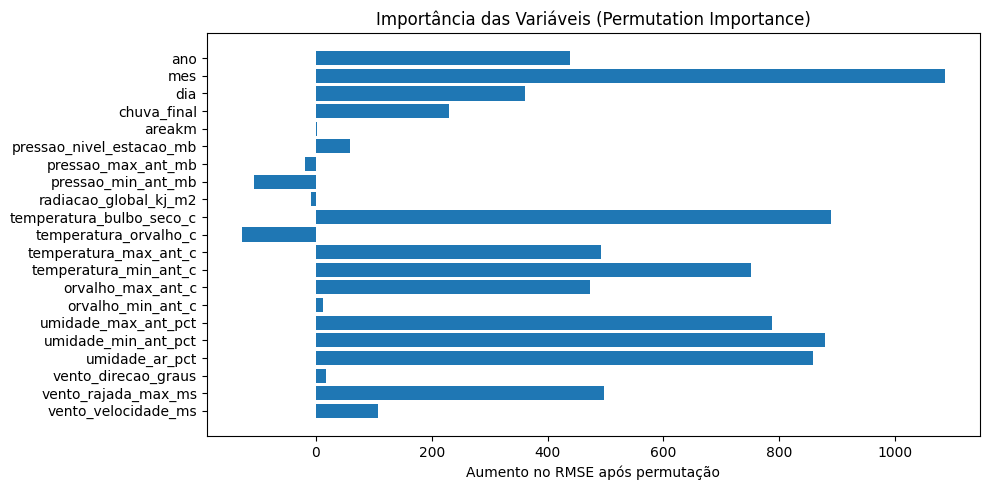

In [43]:
# Modelo LSTM
model = Sequential()
model.add(Input(shape=(lookback, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

# Treinamento
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=0
)

# Predições (treino e teste)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Reversão da normalização
y_train_pred_real = y_train_pred * vazao_std + vazao_mean
y_test_pred_real = y_test_pred * vazao_std + vazao_mean

y_train_real_mean = y_train_real.mean(axis=1)
y_test_real_mean = y_test_real.mean(axis=1)
y_train_pred_mean = y_train_pred_real.mean(axis=1)
y_test_pred_mean = y_test_pred_real.mean(axis=1)

# Função RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# RMSE base (com os dados corretos)
rmse_test_baseline = rmse(y_test_real_mean, y_test_pred_mean)
print(f'RMSE base (teste): {rmse_test_baseline:.2f}')

# Permutation Importance
def permutation_importance_lstm(model, X_test, y_test_real_mean, vazao_mean, vazao_std, n_repeats=3):
    n_vars = X_test.shape[2]
    importances = []

    for var_idx in range(n_vars):
        losses = []
        for _ in range(n_repeats):
            X_permuted = X_test.copy()
            np.random.shuffle(X_permuted[:, :, var_idx])  # embaralha a variável ao longo do tempo
            y_pred_permuted = model.predict(X_permuted)
            y_pred_permuted_real = y_pred_permuted * vazao_std + vazao_mean
            y_pred_mean = y_pred_permuted_real.mean(axis=1)
            loss = rmse(y_test_real_mean, y_pred_mean)
            losses.append(loss)

        importance = np.mean(losses) - rmse_test_baseline
        importances.append(importance)
        print(f'Variável {var_idx}: aumento médio de RMSE = {importance:.2f}')

    return importances

# Nomes das variáveis (adapte conforme o seu conjunto de dados)
feature_names = X_df.columns  # exemplo

# Calcular importâncias
importances = permutation_importance_lstm(
    model, X_test, y_test_real_mean, vazao_mean, vazao_std, n_repeats=3
)
importances.pop(4)

# Visualizar
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel('Aumento no RMSE após permutação')
plt.title('Importância das Variáveis (Permutation Importance)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()